## ROMY Array

### Importing

In [1]:
import os, subprocess
import numpy as np
import matplotlib.pyplot as plt
import obspy
import pandas as pd

from obspy.clients.fdsn import Client, RoutingClient
from obspy.signal.array_analysis import array_transff_wavenumber
from obspy.imaging.cm import obspy_sequential
from obspy.geodetics import locations2degrees
from andbro__querrySeismoData import __querrySeismoData
from tqdm import tqdm
from obspy.core.util import AttribDict

# frompydsm.relab import shiftdim

#from andbro__save_to import __save_to
#from andbro__get_data import __get_data


### Setting Variables

In [2]:
config = {}

config['klim'] = 50.
config['kstep'] = config['klim'] / 100.

config['tbeg'] = obspy.UTCDateTime("2019-05-14T12:17:00.000")
config['tend'] = obspy.UTCDateTime("2019-05-14T14:00:10.000")

config['client'] = RoutingClient("eida-routing")



### Defining Methods

In [3]:
def __get_coordinates(config):

    coords = []
    for i, station in enumerate(config['subarray_stations']):

        net, sta = station.split(".")

        inven = config['fdsn_client'].get_stations(network=net,
                                                   station=sta,
                                                   channel='BHZ',
                                                   starttime=config['starttime'],
                                                   endtime=config['starttime']+86400,
                                                   level='response'
                                                  )


        l_lon =  float(inven.get_coordinates('%s.%s..BHZ'%(net,sta))['longitude'])
        l_lat =  float(inven.get_coordinates('%s.%s..BHZ'%(net,sta))['latitude'])
        height = float(inven.get_coordinates('%s.%s..BHZ'%(net,sta))['elevation'])

        coords.append([l_lon,l_lat, height])

    return np.array(coords)

In [4]:
def __getArrayStations(seed_id, tbeg, tend, fur_coords):

    net, sta, loc, cha  = seed_id.split(".")

    route =  RoutingClient("eida-routing")

    inv_check =route.get_stations(
                            network=net,
                            station=sta,
                            channel=cha,
                            starttime=tbeg,
                            endtime=tend,
                            latitude=fur_coords[0],
                            longitude=fur_coords[1],
                            minradius=0,
                            maxradius=0.1,
                            )

    inv_check.plot(projection="local");

    codes, lon, lat, elev = [], [], [], []
    for h, network in enumerate(inv_check):
        for i, station in enumerate(network):

            codes.append(f'{inv_check[h].code}.{station.code}')
            lon.append(station.longitude)
            lat.append(station.latitude)
            elev.append(station.elevation/1000.)

    frame = pd.DataFrame({'codes': codes, 'lon': lon, 'lat': lat, 'elev': elev})

    return frame

In [5]:
def __calculateDistanceOfStations(array_stations, output="km", ref_station=None):
    '''
    from obspy.geodetics import locations2degrees

    '''

    N = len(array_stations)


    if ref_station is not None:
        dist_in_deg = {}
        station1 = array_stations[array_stations.codes == ref_station]
        lat1, lon1 = station1.lat, station1.lon
        for j, station2 in array_stations.iterrows():
            name = str(station2.codes)
            _dist= locations2degrees(lat1  = lat1,
                                      long1 = lon1,
                                      lat2  = station2[2],
                                      long2 = station2[1],
                                      )
            if output == "km":
                dist_in_deg[name] = _dist[0]*111
            elif output == "deg":
                dist_in_deg[name] = _dist[0]

    else:
        dist_in_deg = np.zeros((N, N))
        for i, station1 in array_stations.iterrows():
            for j, station2 in array_stations.iterrows():
                 _dist = locations2degrees(lat1  = station1[2],
                                          long1 = station1[1],
                                          lat2  = station2[2],
                                          long2 = station2[1],
                                          )
            if output == "km":
                dist_in_deg[i][j] = _dist*111
            elif output == "deg":
                dist_in_deg[i][j] = _dist

    return dist_in_deg

In [6]:
def __plotArrayGeometryAndResponse(array, transff, klim, kstep, names=None, unit=None):

    ## calulcate geometrical center of array
    array_center = [np.median(array[:,0]), np.median(array[:,1])]

    ## find geometrical limits of array
    lon_min, lon_max = np.min(array[:,0]), np.max(array[:,0])
    lat_min, lat_max = np.min(array[:,1]), np.max(array[:,1])

    ## define bounds
    kxmin, kxmax, kymin, kymax = -klim, klim, -klim, klim


    ## _________________________________________________________
    ##
    fig, axes = plt.subplots(1,2, figsize=(16,6))

    fs=12

    if unit == "km":
        xdata = (array[:,0]-array_center[0])*111.
        ydata = (array[:,1]-array_center[1])*111. * np.cos(array[:,1]/180.*np.pi)
        x0, y0 = array_center[0]*111., array_center[1]*111. * np.cos(array[1]/180.*np.pi)
    elif unit == "deg":
        xdata = array[:,0]
        ydata = array[:,1]
        x0, y0 = array_center[0], array_center[1]

    ## ________________________________________________
#     axes[0].plot(xdata, ydata,'kv')
    axes[0].scatter(xdata, ydata, s=35, color='black', marker='v', zorder=3)
    axes[0].scatter(x0, y0, color='red', marker='o', s=25, zorder=2)

    if unit == "km" or unit is None:
        axes[0].set_xlabel('X (km)', fontsize=fs)
        axes[0].set_ylabel('Y (km)', fontsize=fs)

        axes[0].set_ylim([-max(abs(ydata)), max(abs(ydata))])
        axes[0].set_ylim([-max(abs(ydata)), max(abs(ydata))])

    elif unit == "deg":
        axes[0].set_xlabel('Longitude (°)', fontsize=fs)
        axes[0].set_ylabel('Latitude (°)', fontsize=fs)

    axes[0].set_title('Square Array configuration', fontsize=fs+2)

    for x, y, s in zip(xdata, ydata, list(names)):
        axes[0].text(x, y, s, ha="right", va="top")

    ## ________________________________________________
    ax2 = axes[1].pcolor(np.arange(kxmin, kxmax + kstep * 1.1, kstep) - kstep / 2.,
               np.arange(kymin, kymax + kstep * 1.1, kstep) - kstep / 2.,
               transff.T, cmap=obspy_sequential)

    plt.colorbar(ax2, ax=axes[:])
    ax2.set_clim(0., 1.)

    axes[1].set_xlim(kxmin, kxmax)
    axes[1].set_ylim(kymin, kymax)
    axes[1].set_xlabel('wave number (m$^{-1}$)', fontsize=fs)
    axes[1].set_ylabel('wave number (m$^{-1}$)', fontsize=fs)
    axes[1].set_title('ARF Square Array', fontsize=fs+2)

    plt.show()

In [7]:
def __get_aperture(config, reference_station=None):

    from numpy import argmax, array, sqrt
    import obspy

    dists, idx = [], []
    for ii, (lon1, lat1, height1) in enumerate(config['coordinates']):
        for jj, (lon2, lat2, height2) in enumerate(config['coordinates']):
            dist_x, dist_y = obspy.signal.util.util_geo_km(lon1, lat1, lon2, lat2)
            dists.append(sqrt((dist_x*1000)**2+(dist_y*1000)**2))  #convert unit from km to m
            idx.append((ii, jj))

    aperture = max(abs(array(dists)))
    idx_max = int(argmax(abs(array(dists))))
    _ii, _jj = idx[idx_max]

    connection = (config['coordinates'][_ii][0], config['coordinates'][_ii][1],
                  config['coordinates'][_jj][0], config['coordinates'][_jj][1])

    print(f" -> Aperture of Array: {round(aperture,2)} m")
    return aperture, connection

In [8]:
## get station info of FUR

net, sta, loc, cha  = "GR.FUR..BHZ".split(".")

inv_fur = config['client'].get_stations(
                                        network = net,
                                        station = sta,
                                        channel = cha,
                                        starttime = config['tbeg'],
                                        endtime = config['tend']
                                        )

fur_coords = [inv_fur[0][0].latitude, inv_fur[0][0].longitude, inv_fur[0][0].elevation]
fur_coords

[48.1639, 11.2768, 565.0]

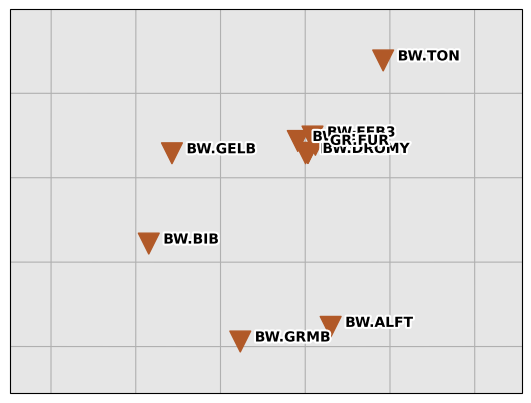

,codes,lon,lat,elev
0,BW.FFB2,11.273684,48.164357,0.577
1,BW.TON,11.288809,48.173897,0.564
2,BW.ALFT,11.279500,48.142334,0.593
3,BW.GELB,11.251400,48.162900,0.628
4,BW.GRMB,11.263500,48.140600,0.656
5,BW.ROMY,11.275476,48.162941,0.571
6,BW.BIB,11.247300,48.152200,0.599
7,BW.FFB1,11.275065,48.162904,0.572
8,BW.DROMY,11.275476,48.162941,0.571
9,BW.FFB3,11.276289,48.164883,0.562


In [9]:
## get all stations around ROMY

array_stations = __getArrayStations("*.*..B*Z", config['tbeg'], config['tend'], fur_coords)

array_stations

## Get Array Aperture

In [11]:
# __get_aperture(config, reference_station=None)

In [2]:
def __array_latlon_to_xyz(array_stations, ref_station="GR.FUR"):
    """Convert angluar to cartesian coordiantes

    latitude is the 90deg - zenith angle in range [-90;90]
    lonitude is the azimuthal angle in range [-180;180] 
    """
    import math
    from numpy import zeros
    import utm

    def __latlon_to_xyz(lat, lon):
        r = 6371 # earth radius
        theta = math.pi/2 - math.radians(lat)
        phi = math.radians(lon)
        x = r * math.sin(theta) * math.cos(phi) # bronstein (3.381a)
        y = r * math.sin(theta) * math.sin(phi)
        z = r * math.cos(theta)
        return x, y, z

    if ref_station not in list(array_stations.codes):
        print(f"-> {ref_station} not vaild")
        return


    for _i in ["x", "y", "z", "utm_zone", "utm_letter"]:
        array_stations[_i] = zeros(array_stations.shape[0])

    sta_ref = array_stations[array_stations.codes == ref_station]
    utm_ref_e, utm_ref_n, utm_zone, utm_letter = utm.from_latlon(float(sta_ref.lat), float(sta_ref.lon))
    z_ref = sta_ref.elev[0]

    for i, sta in array_stations.iterrows():

        utm_e, utm_n, utm_zone, utm_letter = utm.from_latlon(sta.lat, sta.lon)

        array_stations.loc[i, "x"] = round(( utm_e - utm_ref_e ), 2)
        array_stations.loc[i, "y"] = round(( utm_n - utm_ref_n ), 2)
        array_stations.loc[i, "z"] = ( array_stations.loc[i, "elev"] - z_ref ) * 1e3
        array_stations.loc[i, "utm_zone"] = utm_zone
        array_stations.loc[i, "utm_letter"] = str(utm_letter)

    return array_stations

In [3]:
array_stations2 = __array_latlon_to_xyz(array_stations, ref_station="GR.FUR")

NameError: name 'array_stations' is not defined

In [14]:
array_stations2 = array_stations2.drop(columns=["lat", "lon", "elev", "utm_zone", "utm_letter"])

new_codes = []
for code in array_stations2.codes:
    new_codes.append(code.replace(".", "_"))

array_stations2.codes = new_codes

array_stations2.to_csv("/home/andbro/Downloads/mseed/array/"+"setup_romy_array_all", sep=" ", index=False, header=False)


NameError: name 'array_stations2' is not defined

## Compute station distance

In [15]:
__calculateDistanceOfStations(array_stations, output="km", ref_station="GR.FUR")

{'BW.FFB2': 0.2362101659242785,
 'BW.TON': 1.4218750924471393,
 'BW.ALFT': 2.402161512333932,
 'BW.GELB': 1.8838368920747581,
 'BW.GRMB': 2.7674921021816834,
 'BW.ROMY': 0.1447084177578204,
 'BW.BIB': 2.541258440282254,
 'BW.FFB1': 0.16948017717656966,
 'BW.DROMY': 0.1447084177578204,
 'BW.FFB3': 0.11548574338863121,
 'GR.FUR': 0.0}

In [20]:
__calculateDistanceOfStations(array_stations)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.23621017],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.42187509],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        2.40216151],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.88383689],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        2.7674921 ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.14470842],
       [0.        , 0.        , 0.        , 0.        , 0.

### Calulcate Distances, Plot Array Geometry and Response

In [18]:
# dist, dist_max = __calculateDistanceOfStations(array_stations)
dist = __calculateDistanceOfStations(array_stations)


lambda_min = .4*dist_max # in km

config['k_max'] = 2*np.pi/lambda_min
config['k_step'] = config['k_max'] / 100.

coordinates = np.column_stack([array_stations.lon, array_stations.lat, array_stations.elev])

## compute transfer function as a function of wavenumber difference
transff = array_transff_wavenumber(coordinates,
                                   config['k_max'],
                                   config['k_step'],
                                   coordsys='lonlat'
                                   )


__plotArrayGeometryAndResponse(coordinates,
                               transff,
                               config['k_max'],
                               config['k_step'],
                               array_stations.codes,
                               unit="deg",
                              )

NameError: name 'dist_max' is not defined

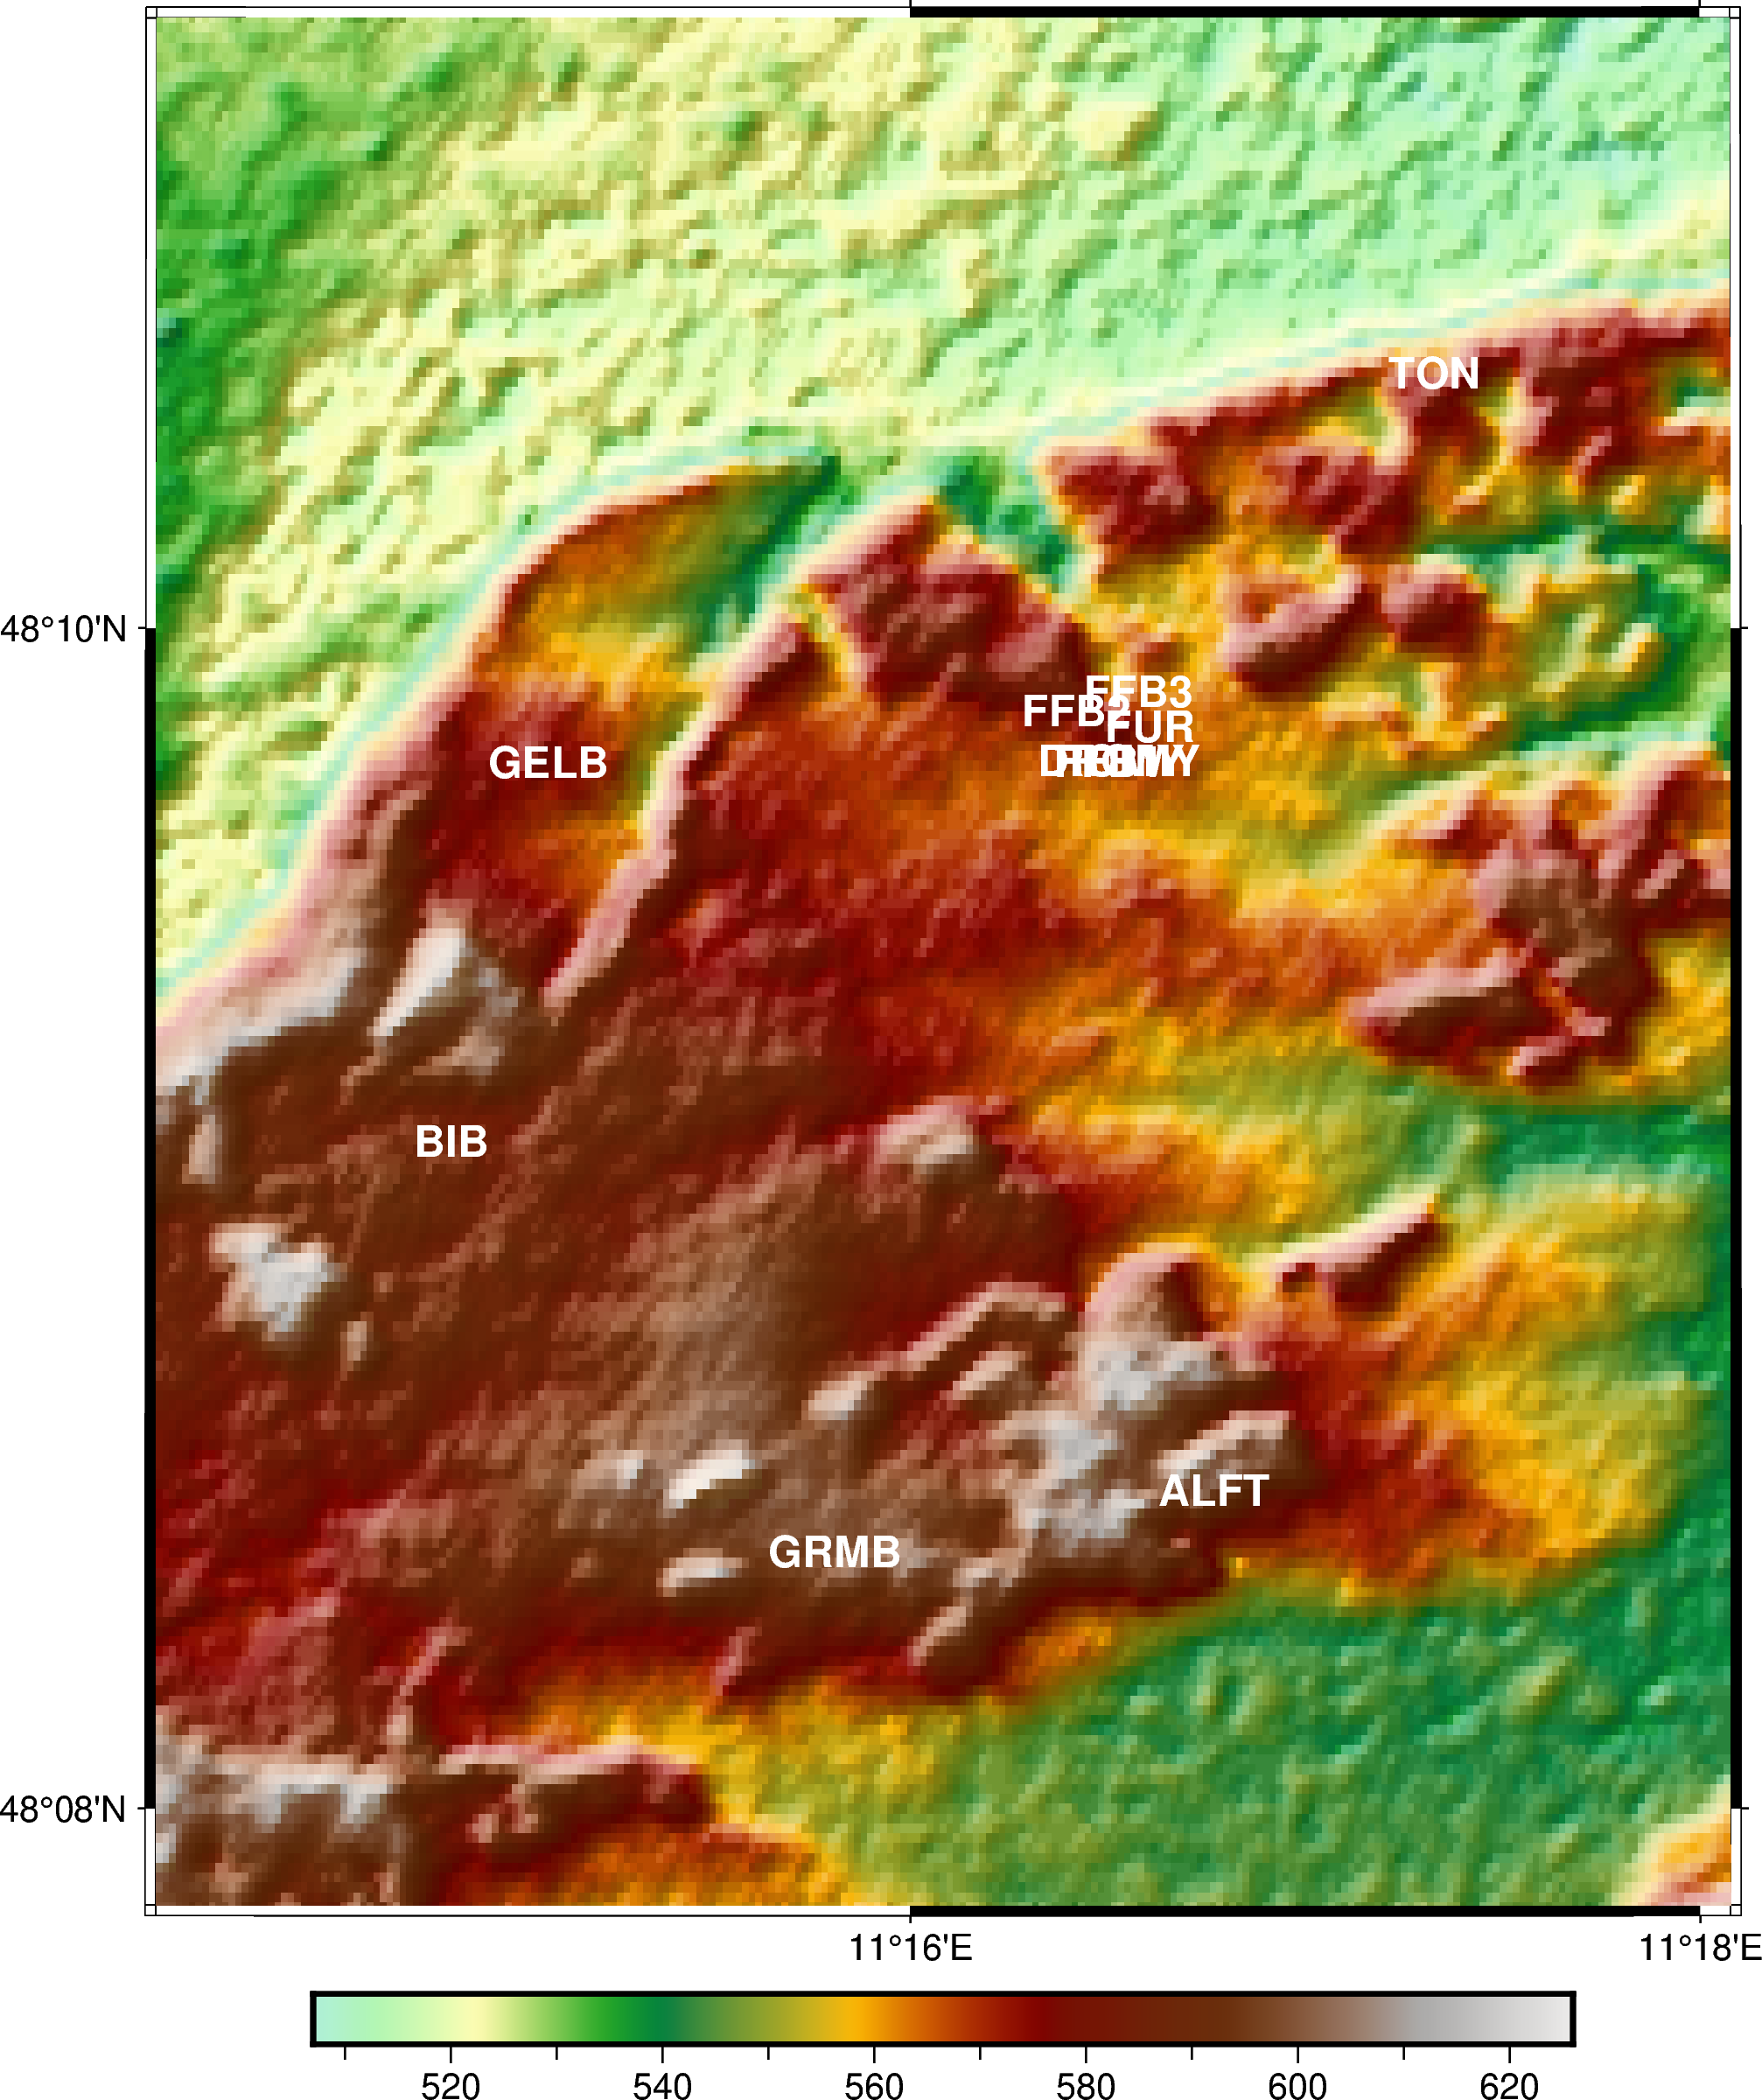

In [19]:
import pygmt

def __getMapParameters(lats, lons):

    # Determine a nice, padded region
    region = [np.min(lons), np.max(lons), np.min(lats), np.max(lats)]
    x_pad = (region[1] - region[0]) * 0.3
    y_pad = (region[3] - region[2]) * 0.3
    region = [region[0] - x_pad, region[1] + x_pad, region[2] - y_pad, region[3] + y_pad]

    # Determine a nice stereographic projection
    lon_0 = np.mean(region[:2])
    lat_0 = np.mean(region[2:])
    ref_lat = 90 if lat_0 > 0 else -90
    projection = f'S{lon_0}/{ref_lat}/6i'

    return region, projection

region, projection = __getMapParameters(array_stations.lat, array_stations.lon)

fig = pygmt.Figure()


fig.coast(
        region=region,
        projection=projection,
        shorelines=True,
        water='lightblue',
        rivers=[1],
        land='lightgrey',
        borders=[1, 2],
        frame='a',
)

KWARGS = dict(
              grid='@srtm_relief_01s',
              region=region,
              projection=projection,
              frame=False,
              shading=True,
              cmap='earth',
             )

fig.grdimage(**KWARGS)


# fig.plot(array_stations.lon,
#          array_stations.lat,
#          style='i0.2i',
#          fill='white',
#          pen=True
#         )

fig.text(x=array_stations.lon,
         y=array_stations.lat,
         text=[code.split(".")[1] for code in array_stations.codes],
         # offset=[0.2, 0.5],
         font="12p,Helvetica-Bold,white"
        )

fig.colorbar()


fig.show()

In [ ]:
import xarray as xr

axis = np.arange(-config['klim'], config['klim']+0.5,0.5)
print( len(axis))

model = xr.DataArray(transff.T, coords=(axis, axis), dims=('lat', 'lon'))


fig = pygmt.Figure()


fig.coast(
        region=region,
        projection=projection,
        shorelines=True,
        water='lightblue',
        rivers=[1],
        land='lightgrey',
        borders=[1, 2],
        frame='a',
)

KWARGS = dict(
              grid=transff.T,
              region=region,
              projection=projection,
              frame=False,
              shading=True,
              cmap='earth',
             )
fig.grdimage(**KWARGS)


fig.plot(array_stations.lon, array_stations.lat, style='i0.2i', color='white', pen=True)

fig.text(x=array_stations.lon, 
         y=array_stations.lat, 
         text=[code.split(".")[1] for code in array_stations.codes],
         offset=[0.2, 0.5],
         font="12p,Helvetica-Bold,white"
        )

fig.colorbar()


fig.show()